In [62]:
import torch
import numpy as np

In [63]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()    

## Equação de Poisson Unidimencional

Considerando a equação de Poisson definida por:

$$
-\bigtriangleup u = \pi^2  \sin(\pi x), \hspace{0.5cm} x \in [-1,1]
$$

com as seguintes condições de Dirichlet: 

$$u(-1) = u(1) = 0$$

e a solução exata é representada por $u(x) = \sin(\pi x)$

In [64]:
#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
def pde(x, model):
    input = x.unsqueeze(-1)

    u = model(input)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    return -u_xx - torch.pi**2 * torch.sin(torch.pi * x)

#DECLARAÇÃO DO DOMÍNIO
x_dom = (-1,1)
batch_size = 100

x = torch.FloatTensor(batch_size).uniform_(x_dom[0], x_dom[1]).requires_grad_()
target = torch.zeros_like(x)
bc1 = torch.tensor([-1.,1.]).unsqueeze(-1)
bc1_target = torch.tensor([0.,0.]).unsqueeze(-1)


#DECLARAÇÃO DA ARQUITETURA USADA
model = NeuralNetwork(1, 1, 20, 1, torch.nn.Tanh()) # 1 input, 1 camada oculta, 20 neurônios/cam. oculta, 1 output, activação: Tanh

#PARAMETROS DO TREINAMENTO
learning_rate = 1e-3
epochs = 5000
optmizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
loss_fn = torch.nn.MSELoss()

In [65]:
#TREINAMENTO
for ep in range(epochs):

    optmizer.zero_grad()

    #CALCULO DO CUSTO PARA A CONDIÇÃO DE CONTORNO
    out_bc1 = model(bc1[0])
    out_bc2 = model(bc1[1])
    l1 = loss_fn(out_bc1, bc1_target[0])
    l2 = loss_fn(out_bc2, bc1_target[1])

    #CALCULO DO CURSTO PARA OS PONTOS INTERNOS
    out = pde(x, model)
    l3 = loss_fn(out, target)

    loss = l1 + l2 + l3
    loss.backward()
    optmizer.step()

    with torch.autograd.no_grad():
        print(f'Epochs: {ep}/{epochs} Loss: {loss.item()}')

Epochs: 0/5000 Loss: 44.30948257446289
Epochs: 1/5000 Loss: 44.228153228759766
Epochs: 2/5000 Loss: 44.149078369140625
Epochs: 3/5000 Loss: 44.0721321105957
Epochs: 4/5000 Loss: 43.99715805053711
Epochs: 5/5000 Loss: 43.92392349243164
Epochs: 6/5000 Loss: 43.85216522216797
Epochs: 7/5000 Loss: 43.78158950805664
Epochs: 8/5000 Loss: 43.71186065673828
Epochs: 9/5000 Loss: 43.642574310302734
Epochs: 10/5000 Loss: 43.573299407958984
Epochs: 11/5000 Loss: 43.50354766845703
Epochs: 12/5000 Loss: 43.43286895751953
Epochs: 13/5000 Loss: 43.36076354980469
Epochs: 14/5000 Loss: 43.286808013916016
Epochs: 15/5000 Loss: 43.210533142089844
Epochs: 16/5000 Loss: 43.13151931762695
Epochs: 17/5000 Loss: 43.04935073852539
Epochs: 18/5000 Loss: 42.96360778808594
Epochs: 19/5000 Loss: 42.87392044067383
Epochs: 20/5000 Loss: 42.77991485595703
Epochs: 21/5000 Loss: 42.6812629699707
Epochs: 22/5000 Loss: 42.577659606933594
Epochs: 23/5000 Loss: 42.468807220458984
Epochs: 24/5000 Loss: 42.35443115234375
Epoc

Erro relativo: 0.9990062117576599


/home/henriquewsl/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


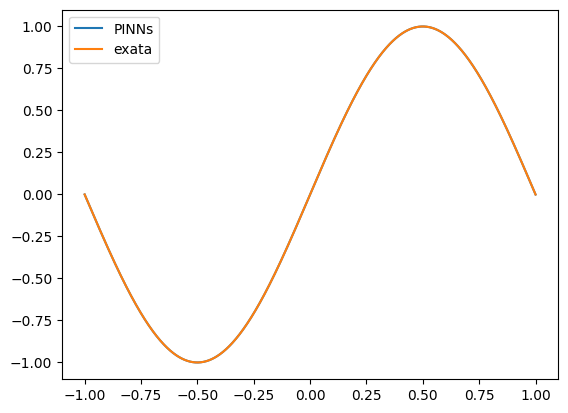

In [66]:
import matplotlib.pyplot as plt 

size = 1000
x_test = torch.linspace(x_dom[0], x_dom[1], size).unsqueeze(-1)
out = model(x_test)

def exata(x): return torch.sin(torch.pi * x)
out_exata = exata(x_test)

#ERRO ENTRE AS SOLUÇÕES
erro = loss_fn(out, out_exata)
print(f'Erro relativo: {erro}')

x_test = x_test.detach().numpy()
out = out.detach().numpy()
out_exata = out_exata.detach().numpy()

#PLOTAGEM
plt.plot(x_test, out, label = 'PINNs')
plt.plot(x_test, out_exata, label = 'exata')
plt.legend()
plt.show()